# Explore differential expression analysis results

In [1]:
import warnings
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time


sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'

## Read best DE results, filter based on number of DE genes and on-target KD effects

In [4]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad')

In [5]:
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
adata_de.X = np.nan_to_num(adata_de.layers['zscore'], 0)

In [6]:
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [44]:
#de_summary_stats[(de_summary_stats.n_total_de_genes>30)&(de_summary_stats.n_cells_target>75)].to_csv('../../metadata/for_DE_by_guide.csv')

In [6]:
# Perturbation selection
mask = (de_summary_stats.n_total_de_genes>30) & (de_summary_stats.n_cells_target>75)# & (de_summary_stats.ontarget_effect_category=='on-target KD')
obs_names_mask = de_summary_stats[mask].obs_names
adata_de_filtered = adata_de[adata_de.obs_names.isin(obs_names_mask)].copy()
adata_de_filtered.var_names = adata_de_filtered.var.gene_name
adata_de_filtered.X = np.nan_to_num(adata_de_filtered.layers['zscore'], 0).copy()

In [7]:
# Mask the on-target zscore
for obs_name in adata_de_filtered.obs_names:
    gene_id = adata_de_filtered[obs_name].obs['target_contrast'].values[0]
    adata_de_filtered[obs_name, adata_de_filtered.var['gene_ids']==gene_id].X=0
adata_de_filtered.layers['masked_zscore'] = adata_de_filtered.X.copy()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_39982/387600065.py:4: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata_de_filtered[obs_name, adata_de_filtered.var['gene_ids']==gene_id].X=0


In [8]:
adata_de_filtered

AnnData object with n_obs × n_vars = 4621 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore', 'masked_zscore'

In [9]:
# Select features with variance in the top 50% and/or top 200 differentially expressed genes for all perturbations ordered by zscores that are significant
zscore = adata_de_filtered.layers['zscore']
padj = adata_de_filtered.layers['adj_p_value']
zscore = zscore*(padj<0.1)
zscore_ranking = np.argsort(zscore, axis=1)
top100_mask = np.sum(((zscore_ranking>(np.max(zscore_ranking)-100))*(zscore>0))|((zscore_ranking<100)*(zscore<0)), axis=0)>0
var_mask = adata_de_filtered.X.var(axis=0)>np.percentile(adata_de_filtered.X.var(axis=0), 50)
adata_de_filtered = adata_de_filtered[:,top100_mask|var_mask].copy()

In [10]:
adata_de_filtered

AnnData object with n_obs × n_vars = 4621 × 7521
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore', 'masked_zscore'

In [11]:
adata_de_filtered.write_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')

In [3]:
adata_load = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')
adata_cluster = adata_load.T

### Simple PCA clustering

In [4]:
sc.pp.scale(adata_cluster)

In [5]:
sc.pp.pca(adata_cluster, n_comps=300)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


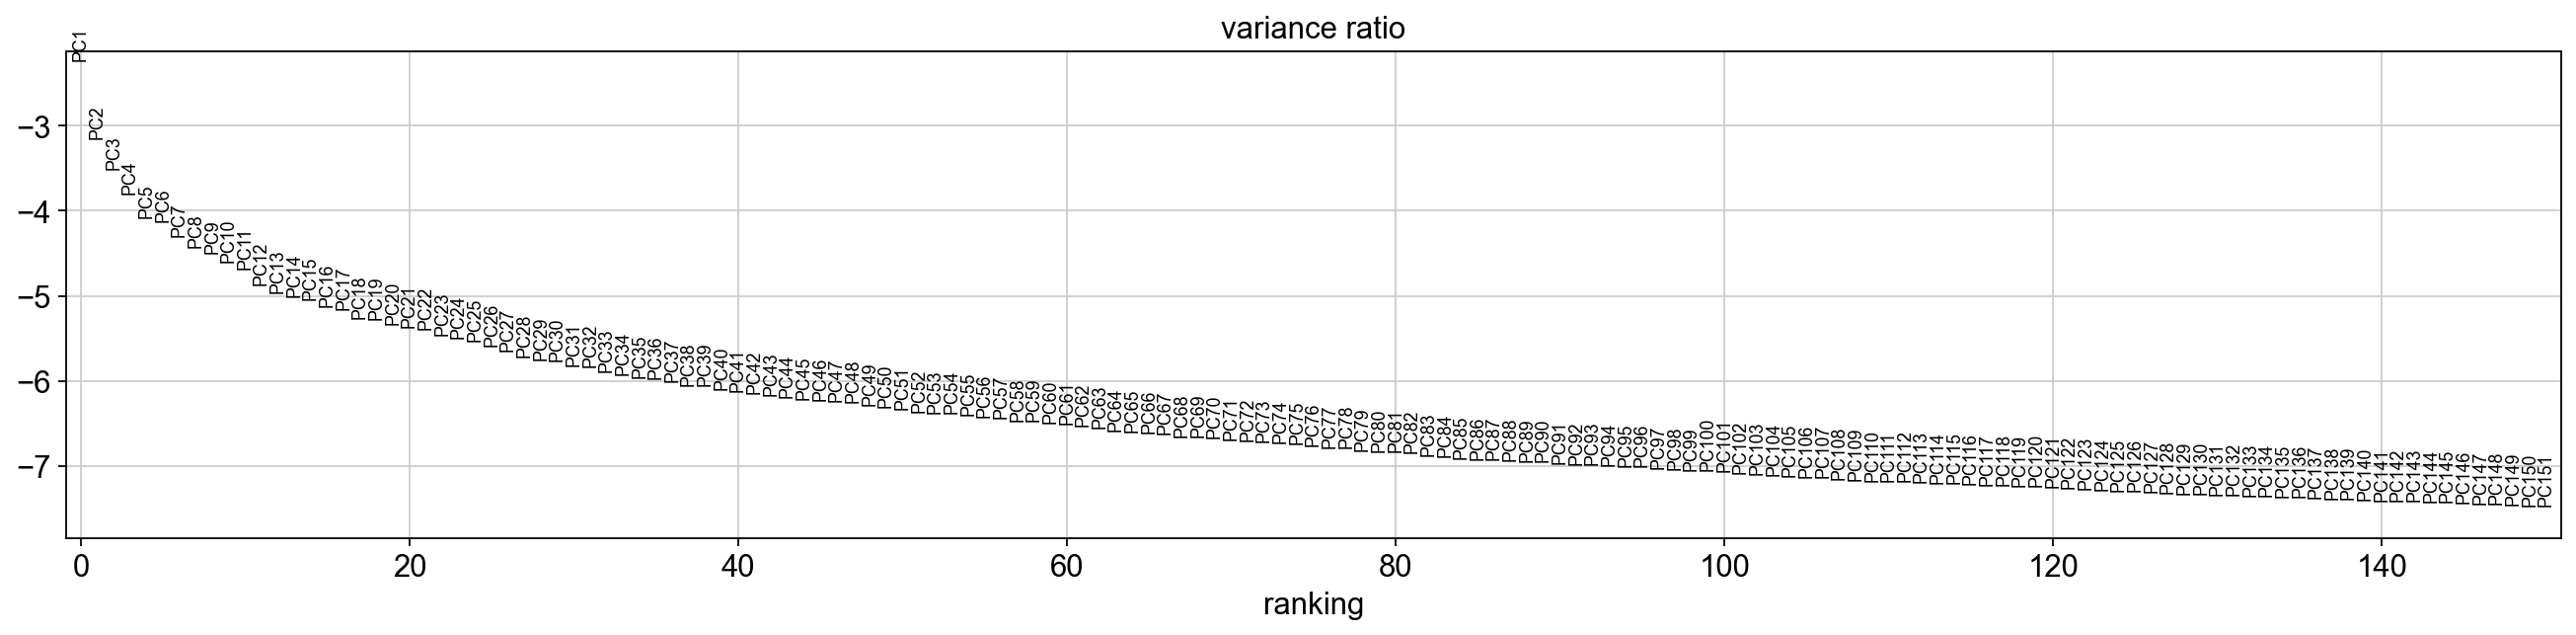

In [6]:
sc.pl.pca_variance_ratio(adata_cluster, n_pcs=150, log=True)

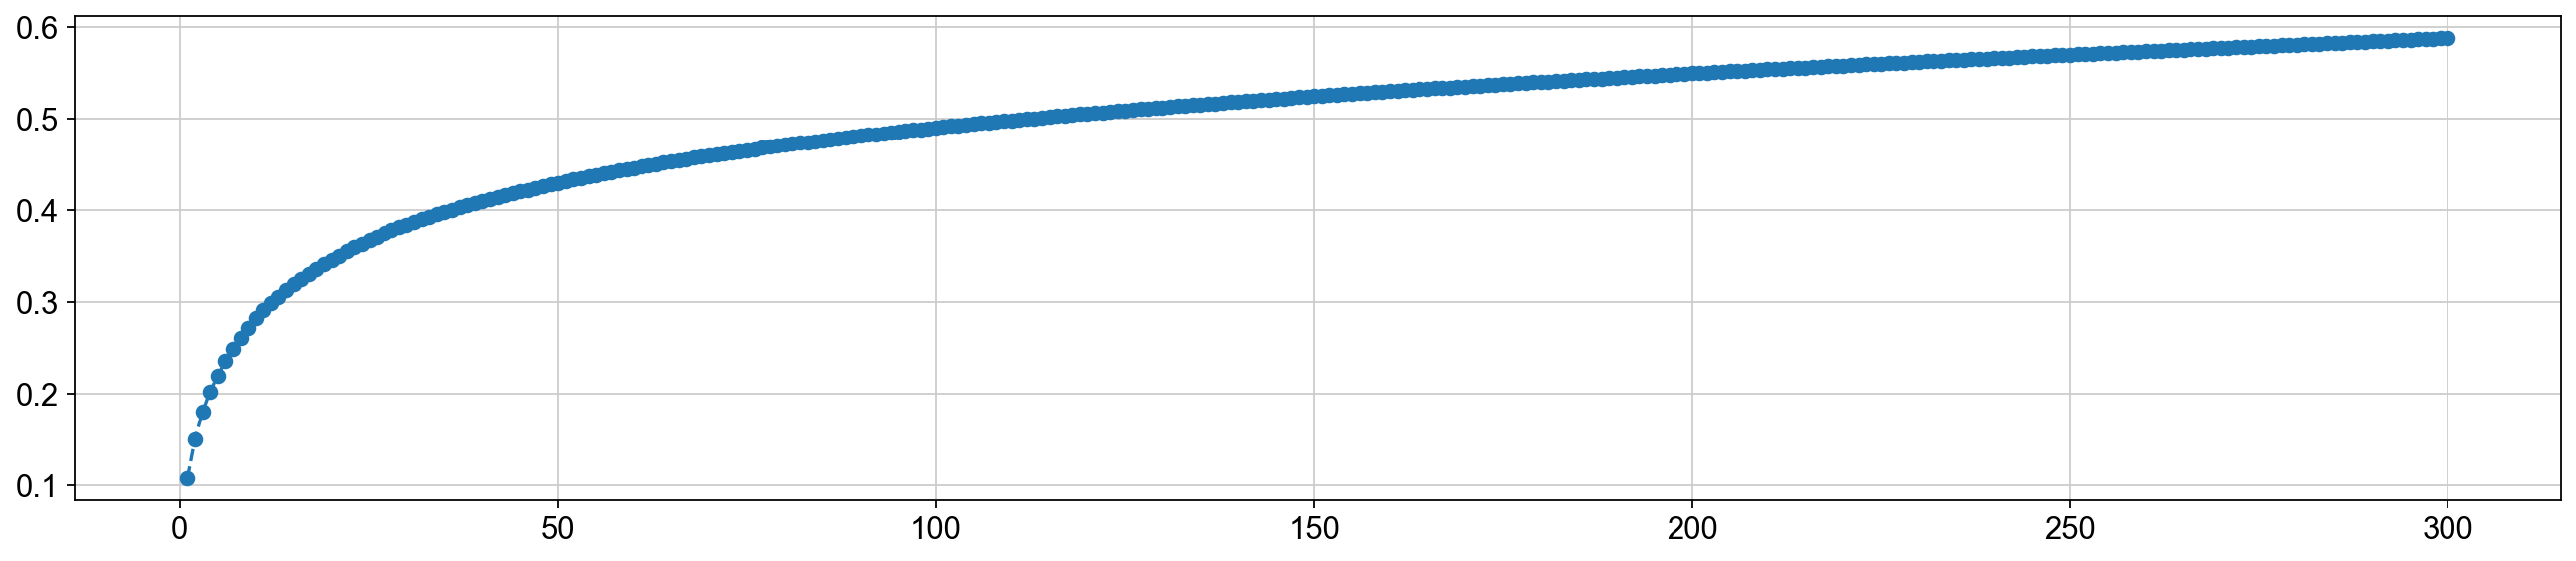

In [7]:
variance_ratio = adata_cluster.uns['pca']['variance_ratio']
cumulative_variance_ratio = np.cumsum(variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')

In [3]:
adata_load = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')
adata_cluster = adata_load.T

In [5]:
def generate_masks(data_length: int, percentage: float, num_times: int, random_seed=42) -> List[List[bool]]:
    np.random.seed(random_seed)
    sample_size = int(data_length * (percentage / 100.0))
    masks = []
    for _ in range(num_times):
        indices = np.random.choice(data_length, size=sample_size, replace=False)
        mask = np.zeros(data_length, dtype=bool)
        mask[indices] = True
        masks.append(mask)
    return masks


def running_clustering(obs_mask, var_mask, n_comp_all=[50,100,150], n_neighbor_all=[7,15,31,63,127], resolution_all=[1.5,2,3,4]):
    warnings.filterwarnings('ignore')
    """
    Running leiden clustering with parameter grid
    """
    N = len(adata_cluster)
    # Subsetting the adata
    adata_tmp = adata_cluster[obs_mask, var_mask].copy()
    # Perform PCA
    sc.pp.scale(adata_tmp)
    sc.pp.pca(adata_tmp, n_comps=max(n_comp_all))
    clustering_batch = []
    for n_comp in n_comp_all:
        for n_neighbor in n_neighbor_all:
            # Perform knn
            sc.pp.neighbors(adata_tmp, n_pcs=n_comp, n_neighbors=n_neighbor, random_state=42)
            for resolution in resolution_all:
                # Perform leiden
                sc.tl.leiden(adata_tmp, resolution=resolution, random_state=42)
                adata_tmp.obs['leiden'] = adata_tmp.obs['leiden'].astype(int)
                adata_tmp.obs['leiden'] = adata_tmp.obs['leiden'].astype('category')
                cluster_labels_numerical = adata_tmp.obs['leiden'].cat.codes
                clustering_tmp = np.full(N, np.nan)
                clustering_tmp[obs_mask] = cluster_labels_numerical
                clustering_batch.append({'n_comp':n_comp,
                                         'n_neighbor':n_neighbor,
                                         'resolution':resolution,
                                         'leiden_assignment': clustering_tmp,
                                         'obs_mask': obs_mask,
                                         'var_mask': var_mask})
    return clustering_batch

In [6]:
N = adata_cluster.shape[0]
M = adata_cluster.shape[1]
num_of_repeat = 150
obs_perc = 80
var_perc = 80
obs_mask_full = [np.full(N, True)] * num_of_repeat
obs_mask_bs = generate_masks(N, obs_perc, num_of_repeat, 42)
var_mask_full = [np.full(M, True)] * num_of_repeat
var_mask_bs = generate_masks(M, var_perc, num_of_repeat, 7)
mask_all = pd.DataFrame({'obs_mask': obs_mask_full+obs_mask_bs,
                         'var_mask': var_mask_bs+var_mask_full})

In [7]:
start_time = time.time()
def run_one_clustering(row):
    return running_clustering(row.obs_mask, row.var_mask)

# Run in parallel
clustering_all = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_one_clustering)(row) for _, row in tqdm(mask_all.iterrows(), total=len(mask_all))
)

clustering_all = [item for sublist in clustering_all for item in sublist]
end_time = time.time()
print(end_time-start_time)

  5%|██▏                                       | 16/300 [00:00<00:03, 77.00it/s]/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  

14517.412001132965


In [8]:
clustering_summary = pd.DataFrame(clustering_all)
#clustering_summary.to_parquet('results/pca_params_screening_de30ntotal75_varfiltered.parquet')
clustering_summary.to_parquet('../../../../3_expts/processed_data/analysis_largefiles/pca_params_screening_nde30ntotal75_transpose_neighbor7127resolution14.parquet')

In [9]:
clustering_summary = pd.read_parquet('../../../../3_expts/processed_data/analysis_largefiles/pca_params_screening_nde30ntotal75_transpose_neighbor7127resolution14.parquet')

### Build consensus matrix

In [16]:
adata_cluster

AnnData object with n_obs × n_vars = 7521 × 4621
    obs: 'gene_ids', 'gene_name'
    var: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [10]:
# Summing all clustering results
n_cells = len(clustering_summary.loc[0, 'leiden_assignment'])
condensed_cooc_matrix_all = np.zeros(n_cells*n_cells)
for i in range(len(clustering_summary)):
    if i % 500 == 0:
        print(i)
    cooc_matrix = np.zeros((n_cells, n_cells), dtype=int)
    run_labels = clustering_summary.loc[i, 'leiden_assignment']
    for label in np.unique(run_labels):
        cell_indices = np.where(run_labels == label)[0]
        # Create a boolean matrix for co-clustered pairs and add to consensus
        co_cluster_pairs = np.ix_(cell_indices, cell_indices)
        cooc_matrix[co_cluster_pairs] += 1 
    condensed_cooc_matrix_all = condensed_cooc_matrix_all + cooc_matrix.flatten()

# Normalize the consensus matrix
norm_cooc_matrix = condensed_cooc_matrix_all.reshape([n_cells, n_cells])/len(clustering_summary)
distance_matrix = 1 - norm_cooc_matrix
sparse_cooc_matrix = csr_matrix(norm_cooc_matrix)

adata_load = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')
adata_cluster = adata_load.T
norm_cooc_matrix_df = pd.DataFrame(data=norm_cooc_matrix,
                                   index=adata_cluster.obs['gene_name'],
                                   columns=adata_cluster.obs['gene_name'])

norm_cooc_matrix_df.to_csv('../../../../3_expts/processed_data/analysis_largefiles/pca_params_screening_nde30ntotal75_transpose_neighbor7127resolution14_cooc_matrix.csv')

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500


In [ ]:
# # Quick check of consensus matrix
# clustermap = sns.clustermap(
#     cooc_corr_matrix,
#     method='ward', metric='euclidean',
#     figsize=(8,8), 
#     cmap='vlag'
# )

<Axes: >

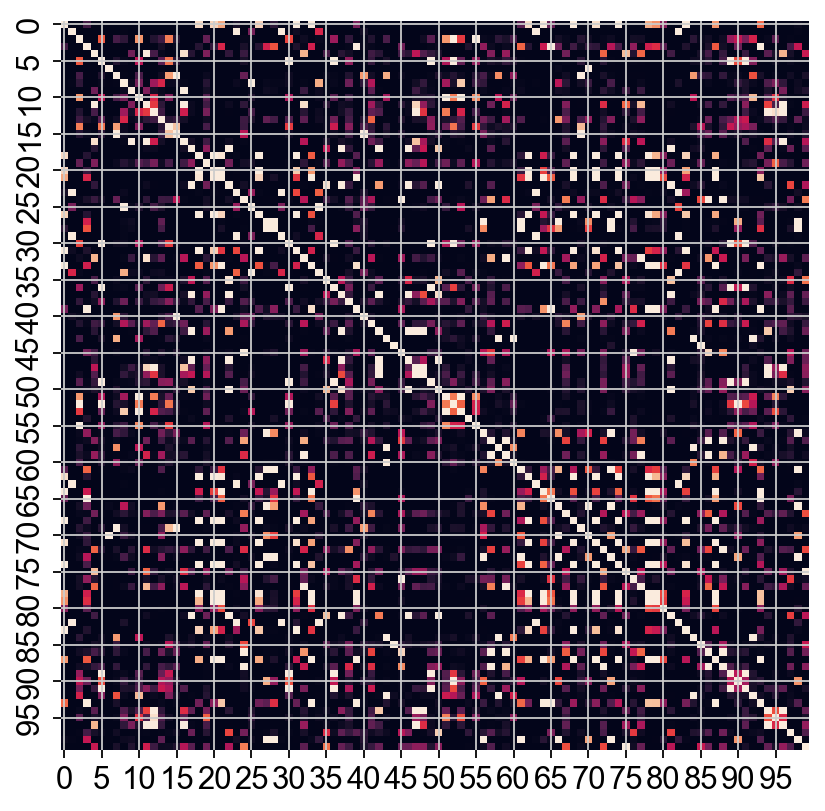

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(norm_cooc_matrix[:100,:100], vmin=0, vmax=0.3, ax=ax, cbar=False)

In [79]:
adata_load = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde30ntotal75_varfiltered.h5ad')
adata_cluster = adata_load.T
norm_cooc_matrix_df = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/pca_params_screening_nde30ntotal75_transpose_neighbor7127resolution14_cooc_matrix.csv', index_col=0)
distance_matrix_df = 1 - norm_cooc_matrix_df
sparse_cooc_matrix = csr_matrix(norm_cooc_matrix_df.values)
np.fill_diagonal(distance_matrix_df.values, 1)

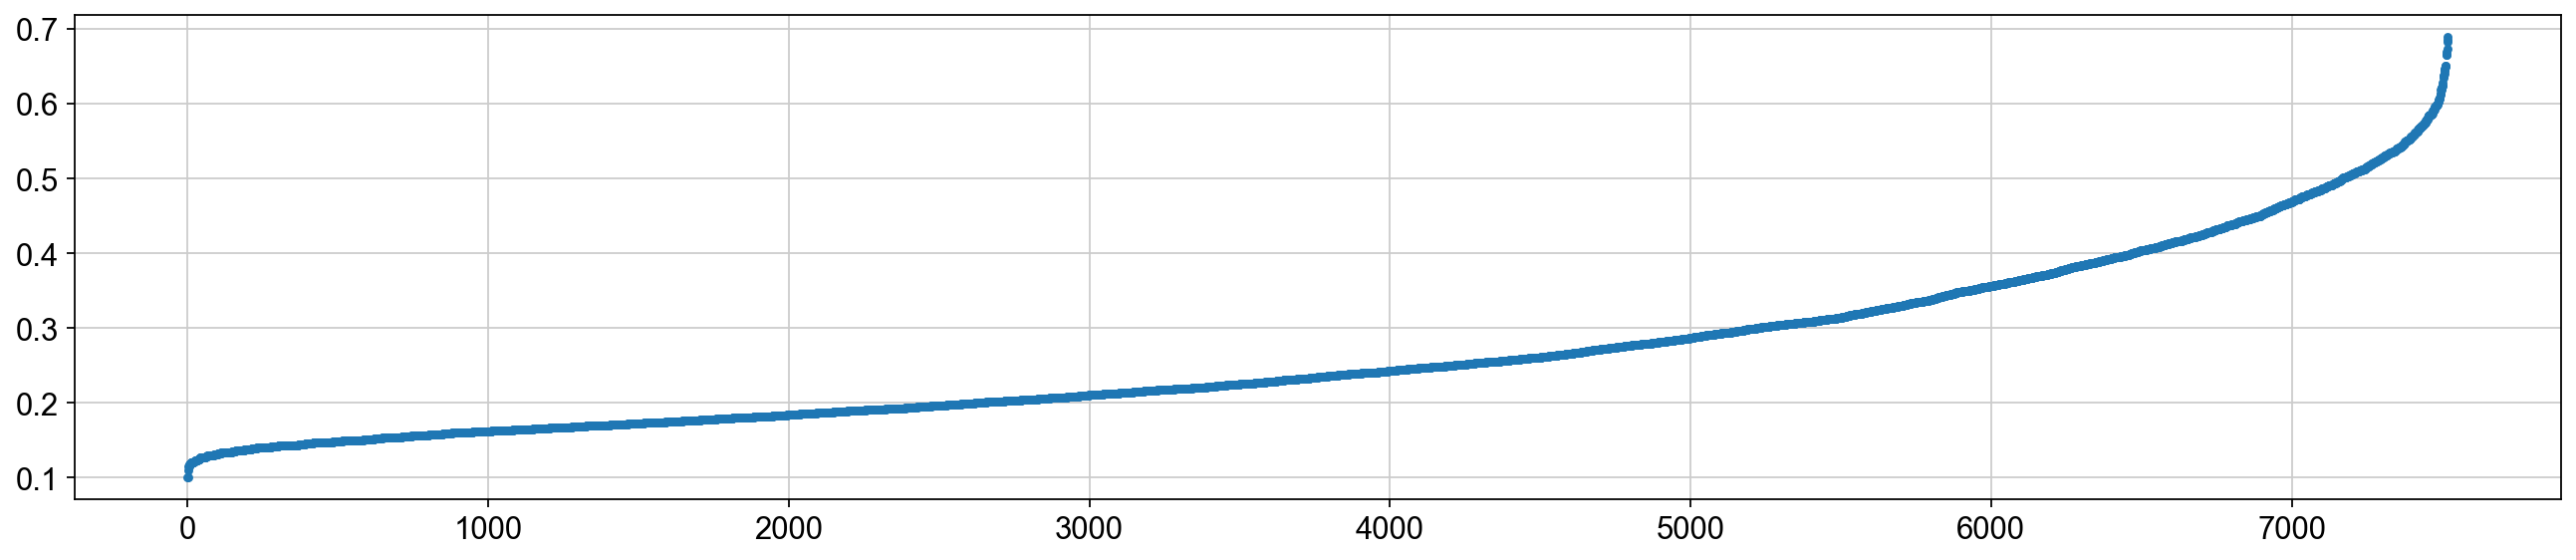

In [80]:
plt.plot(np.sort(distance_matrix_df.min(0)), '.')

In [81]:
# Filter if a perturbation is too far away from other perturbations
distance_matrix_df = distance_matrix_df.loc[distance_matrix_df.min(0)<0.35, distance_matrix_df.min(1)<0.35].copy()
adata_cluster = adata_cluster[distance_matrix_df.index].copy()

In [82]:
# Run hdbscan
clusterer = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=10,
                            min_samples=1, 
                            cluster_selection_method='eom')
clusterer.fit(distance_matrix_df.values)
final_labels = clusterer.labels_
adata_cluster.obs['hdbscan'] = final_labels
adata_cluster.obs['hdbscan'] = adata_cluster.obs['hdbscan'].astype('category')
adata_cluster = adata_cluster[adata_cluster.obs['hdbscan']!=-1].copy()

In [83]:
adata_cluster

AnnData object with n_obs × n_vars = 4369 × 4621
    obs: 'gene_ids', 'gene_name', 'hdbscan'
    var: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [84]:
adata_cluster[adata_cluster.obs['gene_name'].str.startswith(('SMG', 'DPH', 'LAMTOR', 'ELP'))].obs

,gene_ids,gene_name,hdbscan
gene_name,,,
SMG9,ENSG00000105771,SMG9,13
ELP4,ENSG00000109911,ELP4,49
DPH5,ENSG00000117543,DPH5,26
DPH2,ENSG00000132768,DPH2,71
ELP2,ENSG00000134759,ELP2,71
LAMTOR1,ENSG00000149357,LAMTOR1,20
SMG1,ENSG00000157106,SMG1,57
ELP5,ENSG00000170291,ELP5,70


In [85]:
# For each cluster, filter out perturbations that have low correlation with other genes
filter_thres = 0.15
perturbation_to_include = []
for cl in adata_cluster.obs['hdbscan'].unique():
    df = pd.DataFrame(data=adata_cluster[adata_cluster.obs['hdbscan']==cl].layers['zscore'],
                      index=adata_cluster[adata_cluster.obs['hdbscan']==cl].obs_names,
                      columns=adata_cluster.var_names)
    df_corr = df.T.corr()
    np.fill_diagonal(df_corr.values, 0)
    perturbation_to_include = perturbation_to_include + df_corr.loc[df_corr.mean(0)>filter_thres].index.tolist()

adata_cluster = adata_cluster[perturbation_to_include].copy()
distance_matrix_df = distance_matrix_df.loc[perturbation_to_include, perturbation_to_include].copy()

# Rerun hdbscan
clusterer = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=10,
                            min_samples=1,
                            cluster_selection_method='eom')
clusterer.fit(distance_matrix_df.values)
final_labels = clusterer.labels_
adata_cluster.obs['hdbscan'] = final_labels
adata_cluster.obs['hdbscan'] = adata_cluster.obs['hdbscan'].astype('category')
adata_cluster = adata_cluster[adata_cluster.obs['hdbscan']!=-1].copy()

In [86]:
adata_cluster

AnnData object with n_obs × n_vars = 3173 × 4621
    obs: 'gene_ids', 'gene_name', 'hdbscan'
    var: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [87]:
Tcellsignal = ['CD3D','ZAP70','LAT','FYN','ITAM','ITK','GADS','ADAP','GRB2','PLCG1','PLCG2','WAS','RAC2','CD28','DEF6','CD2']

In [88]:
adata_cluster[adata_cluster.obs.gene_name=='TSC1'].obs

,gene_ids,gene_name,hdbscan
gene_name,,,


In [89]:
adata_cluster[adata_cluster.obs.gene_name=='ACLY'].obs

,gene_ids,gene_name,hdbscan
gene_name,,,


In [90]:
adata_cluster[adata_cluster.obs.gene_name.isin(Tcellsignal)].obs

,gene_ids,gene_name,hdbscan
gene_name,,,
ITK,ENSG00000113263,ITK,46
FYN,ENSG00000010810,FYN,10
CD2,ENSG00000116824,CD2,10
WAS,ENSG00000015285,WAS,49
DEF6,ENSG00000023892,DEF6,49
PLCG1,ENSG00000124181,PLCG1,48


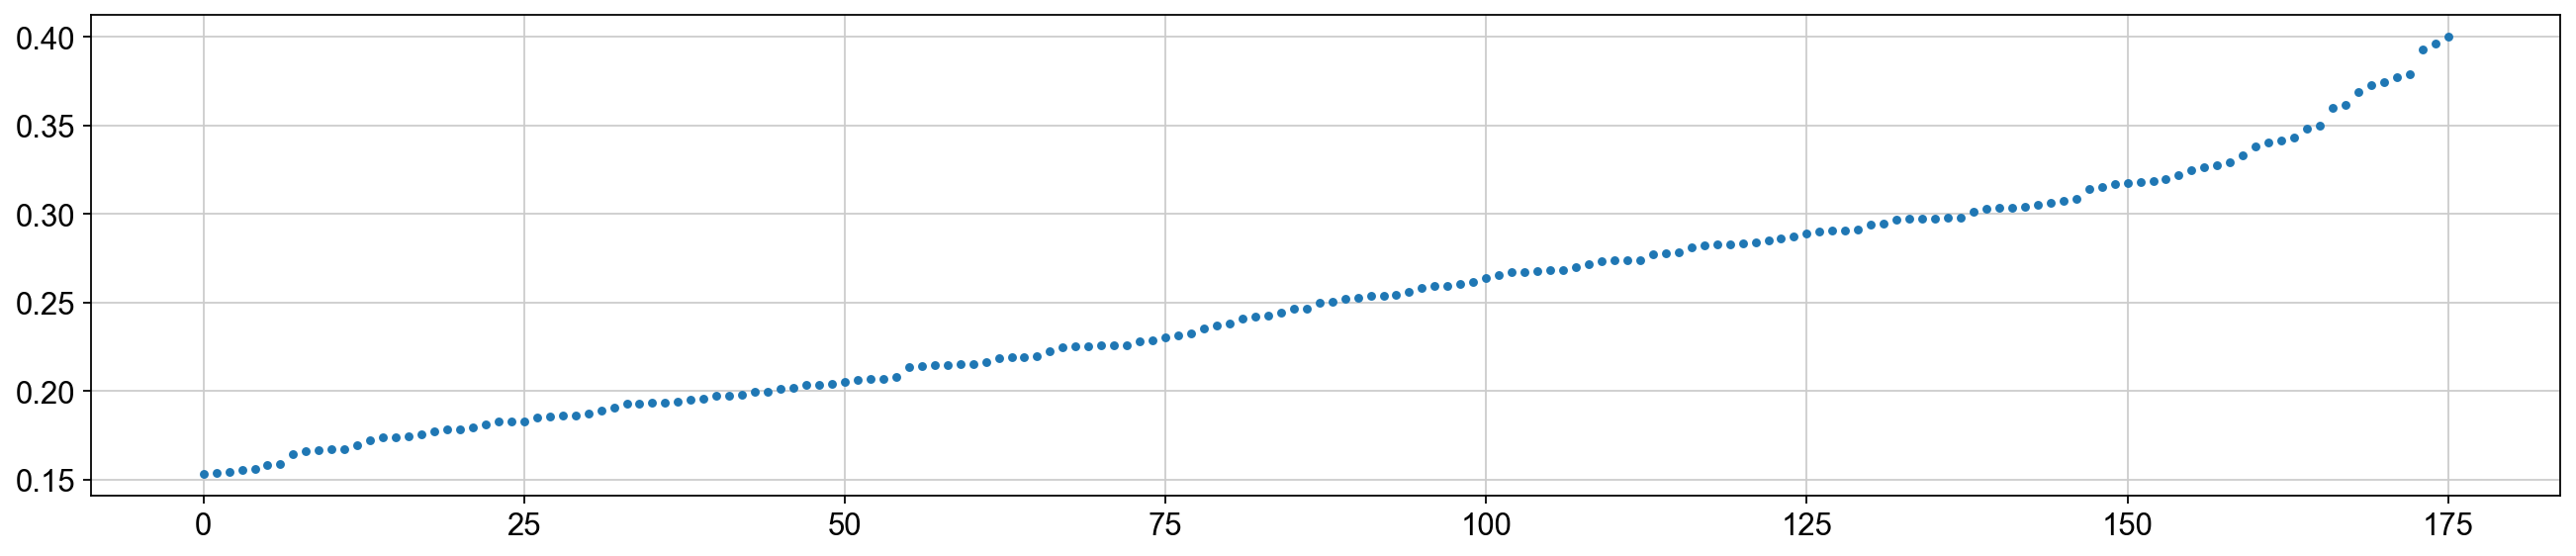

In [91]:
i = 5
df = pd.DataFrame(data=adata_cluster[adata_cluster.obs['hdbscan']==i].layers['zscore'],
                    index=adata_cluster[adata_cluster.obs['hdbscan']==i].obs_names,
                    columns=adata_cluster.var_names)
df_corr = df.T.corr()
np.fill_diagonal(df_corr.values, 0)
plt.plot(np.sort(df_corr.mean(0)), '.')

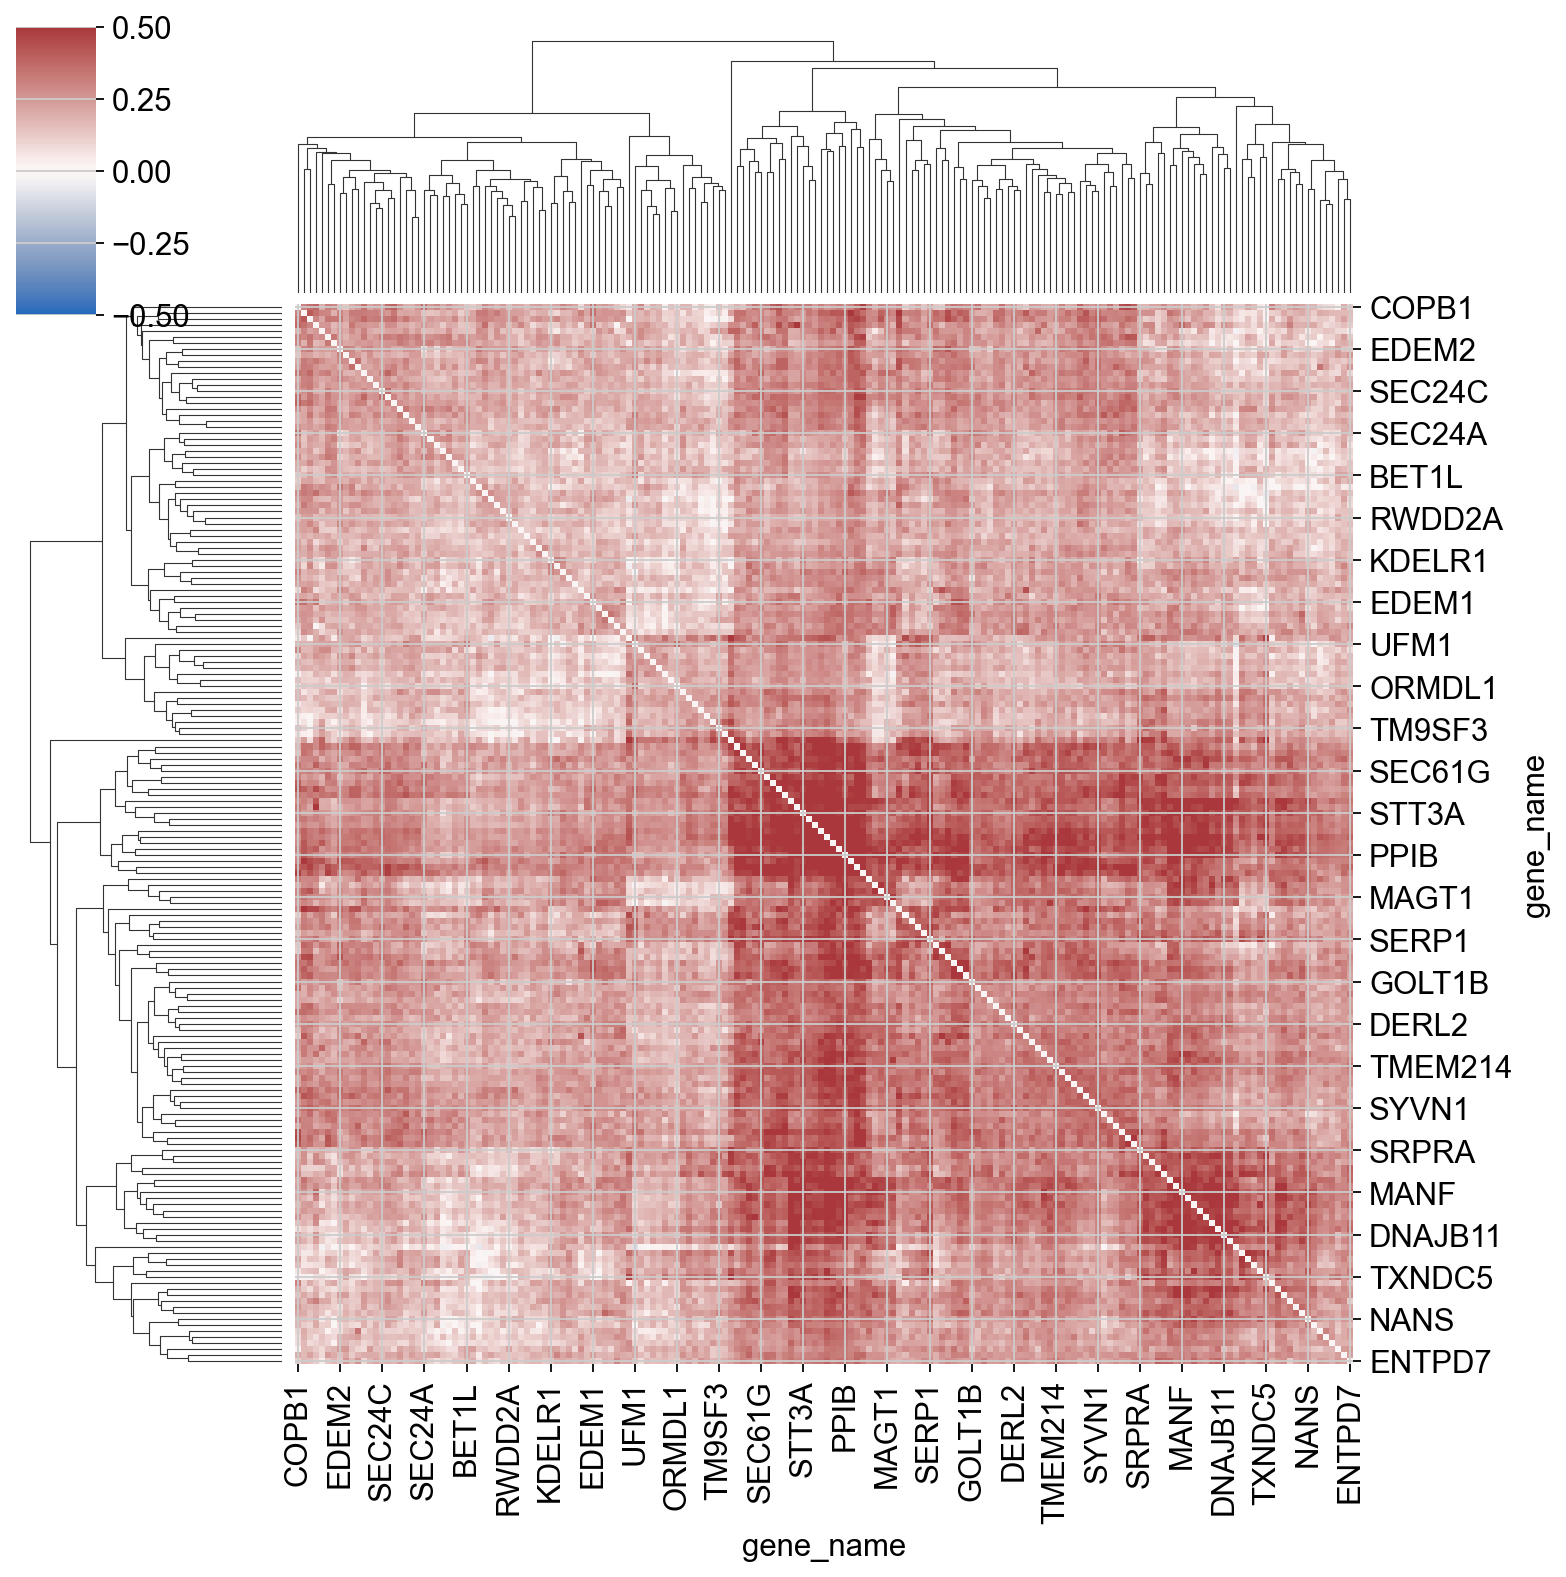

In [92]:
sns.clustermap(df_corr, vmin=-0.5, vmax=0.5, cmap='vlag')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
cluster_label = 'hdbscan'
j = 0
data = adata_cluster[adata_cluster.obs[cluster_label]==j].layers['zscore']
list1 = adata_cluster[adata_cluster.obs[cluster_label]==j].obs.target_contrast_gene_name_corrected.values.tolist()
list2 = adata_cluster[adata_cluster.obs[cluster_label]==j].obs.culture_condition.values.tolist()
ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
for i in range(j,104):
    data = np.concatenate([data, adata_cluster[adata_cluster.obs[cluster_label]==i+1].layers['zscore']])
    list1 = adata_cluster[adata_cluster.obs[cluster_label]==i+1].obs.target_contrast_gene_name.values.tolist()
    list2 = adata_cluster[adata_cluster.obs[cluster_label]==i+1].obs.culture_condition.values.tolist()
    ind = ind +[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
test = pd.DataFrame(data=data,
                    index=ind,
                    columns=adata_cluster.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, vmin=-0.5, vmax=0.5, xticklabels=False, yticklabels=False, cmap='vlag', cbar=False, ax=ax)
plt.tight_layout()

### Filter out low quality hdbscan clusters

In [93]:
np.max(adata_cluster.obs['hdbscan'].astype(int))

52

In [94]:
num_of_cluster = len(adata_cluster.obs['hdbscan'].unique())
cluster_name = []
corr = []
cluster_gene_size = []
cluster_member = []
for i, cl in enumerate(adata_cluster.obs['hdbscan'].unique()):
    df = pd.DataFrame(data=adata_cluster[adata_cluster.obs['hdbscan']==cl].layers['zscore'],
                        index=adata_cluster[adata_cluster.obs['hdbscan']==cl].obs_names,
                        columns=adata_cluster.var_names)
    df_corr = df.T.corr()
    np.fill_diagonal(df_corr.values, 0)
    cluster_name.append(int(cl))
    corr.append(np.mean(df_corr))
    cluster_gene_size.append(len(df))
    cluster_member.append(adata_cluster[adata_cluster.obs['hdbscan']==cl].obs.gene_name.tolist())

cluster_df = pd.DataFrame({'cluster': cluster_name,
                           'intracluster_corr': corr,
                           'cluster_gene_size': cluster_gene_size,
                           'cluster_member': cluster_member})

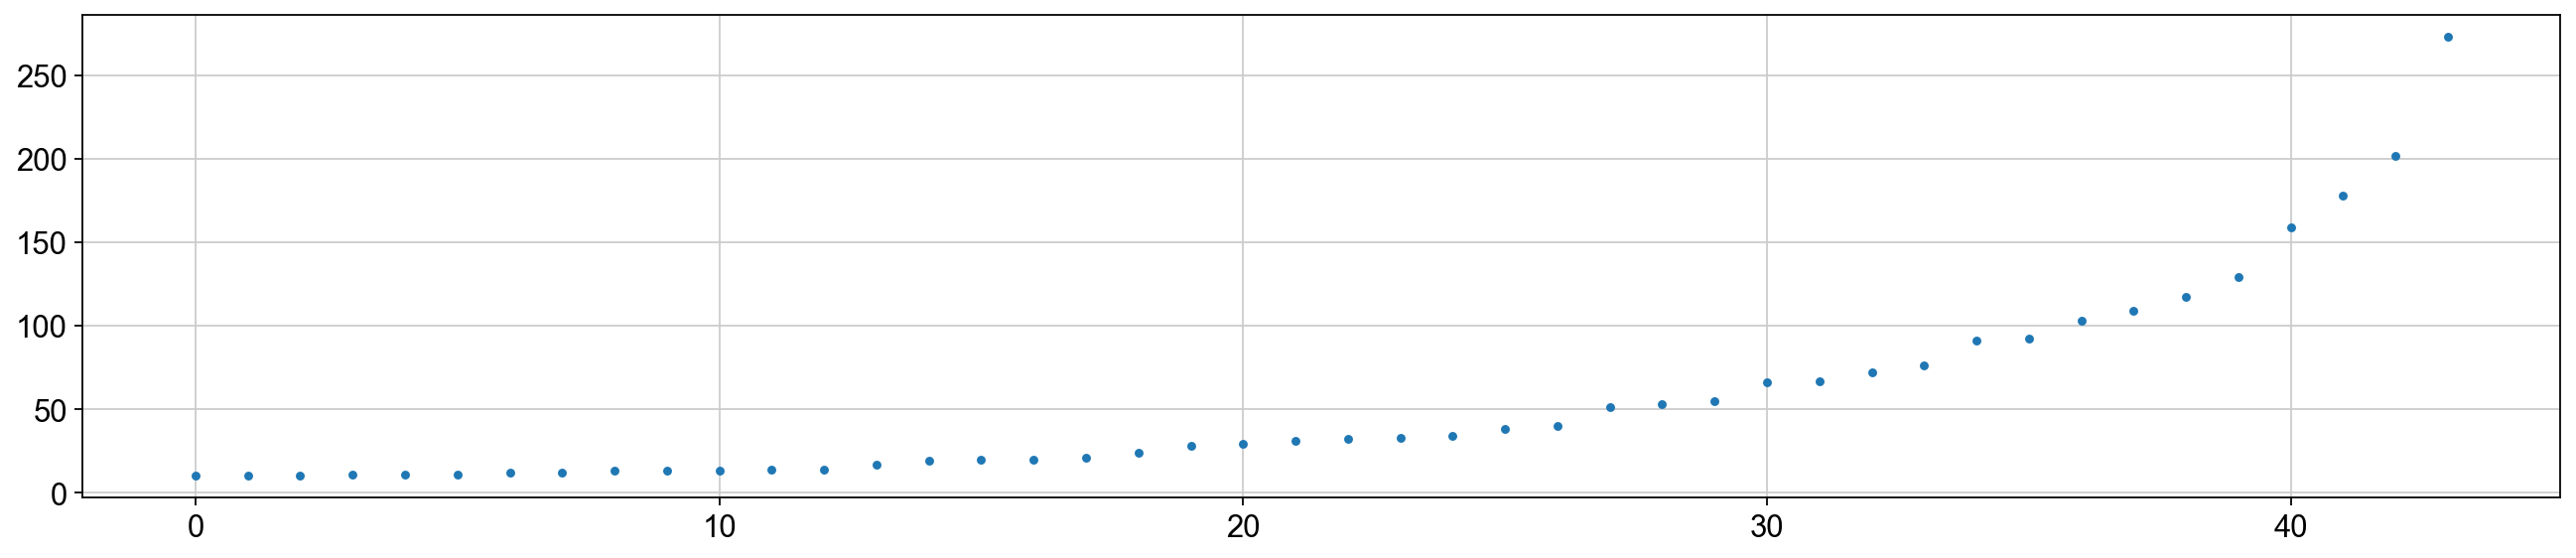

In [75]:
plt.plot(np.sort(cluster_df['cluster_gene_size']), '.')

In [95]:
adata_cluster

AnnData object with n_obs × n_vars = 3173 × 4621
    obs: 'gene_ids', 'gene_name', 'hdbscan'
    var: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [96]:
adata_final = adata_cluster.copy()
#adata_final.obs.loc[adata_final.obs['hdbscan'].isin(cluster_df[cluster_df['intracluster_corr']<0.2]['cluster']), 'hdbscan'] = -1
#adata_final.obs.loc[adata_final.obs['hdbscan'].isin(cluster_df[cluster_df['cluster_gene_size']<3]['cluster']), 'hdbscan'] = -1
#adata_final.obs['hdbscan'] = adata_final.obs['hdbscan'].astype('category')
#adata_final = adata_final[adata_final.obs.hdbscan!=-1].copy()

In [98]:
adata_final.write_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_downstream_clustering_additional_filtering.h5ad')

In [3]:
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_downstream_clustering_additional_filtering.h5ad')

In [7]:
adata_final

AnnData object with n_obs × n_vars = 3016 × 4621
    obs: 'gene_ids', 'gene_name', 'hdbscan'
    var: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'